How similar are two assets, given their returns? When we calculate the covariance matrix of assets, we are answering the question by implicitly treating returns as the features of the assets. A common technique is to run [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) on the covariance matrix and summarize all the return data into a few important and orthorgonal dimensions. We can assess the similarity of two assets with their distance the low-dimensional latent space.

PCA however has a few shortcomings. E.g., PCA on daily returns only takes into account co-movement on the same day and fails to incorporate information on long-term or medium-term trend. PCA on price tracks is not necessarily a better option, as it only considers linear relationships between track values on the same date.

We can consider using [autoencoder](https://en.wikipedia.org/wiki/Autoencoder) as an alternative that can holistically learn patterns from the price tracks and reduce the data into fewer dimensions. I will compare the two dimension reduction techniques with S&P 500 constituents returns. The data consists of 6 years of daily returns pulled from Yahoo Finance API.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

In [2]:
%matplotlib inline
plt.style.use('seaborn')

In [3]:
data = pd.read_csv('./fixtures/snp_rtn.csv').set_index('date')
data.index = pd.to_datetime(data.index)
print(f'S&P 500 constituents daily returns from {data.index[0]} to {data.index[-1]}')
print(f'Stocks excluded for missing data: {", ".join(data.columns[data.isna().any(axis=0)].values)}')
data = data.loc[:, ~data.isna().any(axis=0)]
tickers = data.columns[~data.isna().any(axis=0)].values

S&P 500 constituents daily returns from 2016-03-30 00:00:00 to 2022-03-30 00:00:00
Stocks excluded for missing data: CARR, CDAY, CEG, CTVA, DOW, FOX, FOXA, FTV, HWM, IR, LW, MRNA, OGN, OTIS


In [4]:
track_data = (data + 1).cumprod(0)
X = track_data.values.T

m = X.shape[0]
n = X.shape[1]
print(f'Dataset has {m} stocks and {n} days of return')

latent_d = 5
print(f'Reduce feature space into {latent_d}-dimensional latent space')

Dataset has 491 stocks and 1513 days of return
Reduce feature space into 5-dimensional latent space


In [5]:
max_value = np.max(np.abs(np.log(X)))
def scale(X):
    return np.log(X) / max_value
    
def inverse_scale(X):
    return np.exp(X * max_value)

X_scaled = scale(X)
train_X, valid_X = train_test_split(X_scaled, train_size=0.85, random_state=0)

To train the autoencoder, I split the data into a training set and a validation set. The validation set helps us avoid overfitting when training the autoencoder. 

In [6]:
batch_size = 128
train_data = TensorDataset(torch.tensor(train_X, dtype=torch.float32))
valid_data = TensorDataset(torch.tensor(valid_X, dtype=torch.float32))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [8]:
# Encoder class
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.elu_stack = nn.Sequential(
            nn.Linear(n, 800),
            nn.ELU(),
            nn.Linear(800, 400),
            nn.ELU(),
            nn.Linear(400, latent_dims),
        )
    def forward(self, x):
        x = self.elu_stack(x)
        return x

# Decoder class
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.elu_stack = nn.Sequential(
            nn.Linear(latent_dims, 400),
            nn.ELU(),
            nn.Linear(400, 800),
            nn.ELU(),
            nn.Linear(800, n),
        )
    def forward(self, x):
        x = self.elu_stack(x)
        return x

In [9]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

The autoencoder encodes the return tracks into a 5-dimensional latent variable, then decodes it back to the original return track. The model parameters are tuned to minimize the difference between the original return tracks and the reconstrcuted tracks. We use squared difference as the loss function of the autoencoder training. It is the same objective as PCA's maximization of variance explained.

In [10]:
mesloss= nn.MSELoss()
torch.manual_seed(48)
model = Autoencoder(latent_dims=latent_d)
model.to(device)

Autoencoder(
  (encoder): Encoder(
    (elu_stack): Sequential(
      (0): Linear(in_features=1513, out_features=800, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=800, out_features=400, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=400, out_features=5, bias=True)
    )
  )
  (decoder): Decoder(
    (elu_stack): Sequential(
      (0): Linear(in_features=5, out_features=400, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=400, out_features=800, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=800, out_features=1513, bias=True)
    )
  )
)

In [11]:
# Training function
def train_epoch(dataloader, model, optimizer):
    # Set train mode for both the encoder and the decoder
    model.train()
    train_loss = 0.0
    for x in dataloader: 
        x = x[0].to(device)
        x_hat = model(x)
        # Evaluate loss
        loss = mesloss(x, x_hat)
        # Backpropagation
        optimizer.zero_grad()
        nn.utils.clip_grad_norm_(model.parameters(), 0.1) # Clip gradient
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
    return train_loss / len(dataloader.dataset)

In [12]:
# Validation function
def valid_epoch(dataloader, model):
    # Set evaluation mode for encoder and decoder
    model.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x in dataloader:
            x = x[0].to(device)
            x_hat = model(x)
            loss = mesloss(x, x_hat)
            val_loss += loss.item()
    return val_loss / len(dataloader.dataset)

In [13]:
def train_model(max_epochs):
    lr = 1e-4 # learning rate
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    train_loss = np.empty(0)
    valid_loss = np.empty(0)
    min_loss_epoch_i = 0
    for epoch_i in range(max_epochs):
        train_loss = np.append(train_loss, train_epoch(train_loader, model, optim))
        valid_loss = np.append(valid_loss, valid_epoch(valid_loader, model))
        if valid_loss[min_loss_epoch_i] > valid_loss[-1]:
            min_loss_epoch_i = epoch_i
        # Stop early if validation loss has not decreased for the last 1000 epochs
        if epoch_i - min_loss_epoch_i > 1000: 
            break;
    print(f"Training ends after {epoch_i} epochs")
    return train_loss, valid_loss, epoch_i

To save time, the autoencoder will use parameters from my previous training. If you want to train the model, you can set `use_pretrain_model` to False.

In [14]:
use_pretrain_model = True

if use_pretrain_model:
    model.load_state_dict(torch.load(
        './fixtures/autoencoder_pretrain.pt', 
        map_location=torch.device(device)
    ))
else:
    train_loss, valid_loss, _ = train_model(40000)
    fig, ax = plt.subplots(1, 2, figsize=(12,6))

    ax[0].plot(np.arange(train_loss.size) + 1, train_loss, c='b', label='train')
    ax[0].plot(np.arange(valid_loss.size) + 1, valid_loss, c='r', label='valid')
    ax[0].legend()
    ax[0].set(ylabel='loss', xlabel='epoch', title='Validation Curve')
    ax[1].scatter(np.arange(train_loss.size) + 1, train_loss, c='b', marker='.', label='train', alpha=0.6)
    ax[1].scatter(np.arange(valid_loss.size) + 1, valid_loss, c='r', marker='.', label='valid', alpha=0.6)
    ax[1].legend()
    ax[1].set(ylabel='loss', xlabel='epoch', title='Validation Curve Close-up')
    ax[1].set_ylim(
        min(np.min(train_loss), np.min(valid_loss)),
        max(np.percentile(train_loss, [75])[0], np.percentile(valid_loss, [75])[0])
    )
    print(f'Final validation loss {valid_loss[-1]}')

With the trained autoencoder, we can use it to convert the return tracks into variables in the latent space. We can compare it with dimension reduction conducted with PCA. The latent variables should retain the most meaningful information in the original data set. This means we can find meaningfully similar stocks by searching for nearest neighbors in the latent space.

In [15]:
with torch.no_grad():
    model.encoder.eval()
    latent_auto = model.encoder(torch.tensor(X_scaled, dtype=torch.float32).to(device)).cpu().numpy()

In [16]:
pca = PCA(n_components=latent_d)
pca.fit(X_scaled) 
latent_pca = pca.transform(X_scaled)

In [17]:
nn_model = NearestNeighbors()
nn_pca = NearestNeighbors()
nn_model.fit(latent_auto)
nn_pca.fit(latent_pca);

In [18]:
def find_row_id(ticker):
    result = np.argwhere(tickers == ticker)
    if result.size == 0:
        raise ValueError(f'Cannot find ticker matching {ticker}')
    return result[0][0]

def show_neighbors(ticker, n_neighbors):
    row_i = find_row_id(ticker)
    print(f"{ticker} Nearest Neighbors")
    neighbors_model = nn_model.kneighbors(latent_auto[row_i:row_i+1], n_neighbors=n_neighbors+1)
    neighbors_pca = nn_pca.kneighbors(latent_pca[row_i:row_i+1], n_neighbors=n_neighbors+1)
    columns=pd.MultiIndex.from_product([['Autoencoder', 'PCA'],['Distance', 'Ticker']])
    nn_df = pd.DataFrame((np.array([
            neighbors_model[0][0,1:],
            tickers[neighbors_model[1][0,1:]],
            neighbors_pca[0][0,1:],
            tickers[neighbors_pca[1][0,1:]]
        ])).T,
        columns=columns
    )
    nn_df.index = nn_df.index + 1
    print(nn_df)
    fig, ax = plt.subplots(2, 1, figsize=(12, 9))
    fig.subplots_adjust(hspace=0.3)
    for i in range(2):
        ax[i].plot(data.index, X[row_i]-1, c='k', label=ticker)
        ax[i].set(ylabel='Cumulative return')
        ax[i].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        ax[i].legend()
    for i in range(n_neighbors):
        ax[0].plot(
            data.index, 
            X[neighbors_model[1][0,i+1]]-1, 
            alpha=0.8, 
            c=plt.cm.get_cmap('winter', n_neighbors + 1)(i), 
            label=tickers[neighbors_model[1][0,1+i]]
        )
        ax[1].plot(
            data.index, 
            X[neighbors_pca[1][0,i+1]]-1, 
            alpha=0.8, 
            c=plt.cm.get_cmap('autumn', n_neighbors + 1)(i), 
            label=tickers[neighbors_pca[1][0,1+i]]
        )
    ax[0].set(xlabel='Date',title='Autoencoder Nearest Neighbors')
    ax[1].set(xlabel='Date', title='PCA Nearest Neighbors')
    ax[0].legend()
    ax[1].legend()

Using Nvidia (NVDA) as an example, we see meaningful differences in the two latent representations. In the autoencoder latent space, the nearest neighbor is another semiconductor company, AMD. In the PCA latent space, Etsy, a e-commerce company, is surprisingly the nearest neighbor. This happens because Etsy's return track is closer to Nvidia's return track numerically. Yet, the autoencoder is able to recognize the co-movement between Nvidia and AMD after 2019, even though their tracks are not close numerically. Their distance is notably smaller as the autoencoder can recognize non-linear relationships and pick the most meaningful features.

NVDA Nearest Neighbors
  Autoencoder             PCA       
     Distance Ticker Distance Ticker
1     2.86287    AMD  3.81812   ETSY
2     3.84637   ETSY   3.8527   MTCH
3     4.05866   MTCH  3.85971    AMD


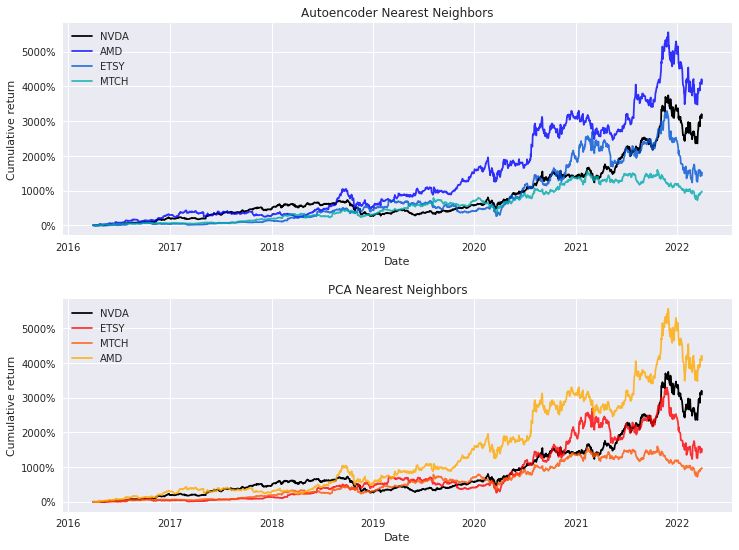

In [19]:
show_neighbors('NVDA', n_neighbors=3)

For Bank of America (BAC), the autoencoder places Raymond James Financial (RJF), an independent investment bank and financial services company, as one of the nearest neighbors while PCA picks NetApp (NTAP), a cloud data services company. Although the return track of Raymond James Financial is consistently below that of Bank of America, they share similar movements. PCA picks a company with a numerically closer return track and ignores the absence of co-movement. We again see the autoencoder's advantage in capturing the return track pattern holistically.

BAC Nearest Neighbors
  Autoencoder              PCA       
     Distance Ticker  Distance Ticker
1    0.643016     RF  0.731182     RF
2    0.800201    RJF  0.826664   NTAP
3    0.821941    JPM  0.910063    JPM


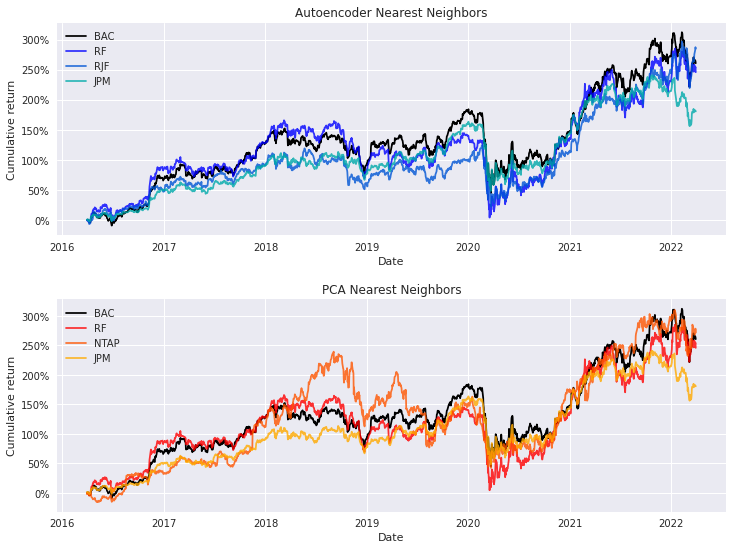

In [20]:
show_neighbors('BAC', n_neighbors=3)

In [21]:
def show_latent(ticker, delta=1):
    row_i = find_row_id(ticker)
    with torch.no_grad():
        model.decoder.eval()
        latent_delta = np.zeros([latent_d * 2 + 1, latent_d])
        latent_delta[0] = latent_auto[row_i]
        for i in range(latent_d):
            latent_delta[1 + i * 2] = latent_delta[0]
            latent_delta[2 + i * 2] = latent_delta[0]
            latent_delta[1 + i * 2, i] -= delta
            latent_delta[2 + i * 2, i] += delta
        X_recon = inverse_scale(
            model.decoder(torch.tensor(latent_delta, dtype=torch.float32).to(device)).cpu().numpy()
        )
        fig, ax = plt.subplots(latent_d // 2 + 1, 2, figsize=(12, latent_d * 2.5), sharey='all')
        fig.subplots_adjust(hspace=0.3, wspace=0.1)
        for i in range(latent_d):
            if i % 2 == 0:
                ax[i // 2][i % 2].set(ylabel='Cumulative return')
            ax[i // 2][i % 2].plot(data.index, X_recon[2 + i*2], c='mediumblue', label=rf"+{delta}")
            ax[i // 2][i % 2].plot(data.index, X_recon[1 + i*2], c='dodgerblue', label=rf" -{delta}")
            ax[i // 2][i % 2].plot(data.index, X_recon[0], c='k')
            ax[i // 2][i % 2].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
            ax[i // 2][i % 2].set(xlabel='Date', title=f"Latent dimension {i+1}")
        ax[0][0].legend(fontsize='12', loc='upper left')
        plt.setp(ax[1][1].get_xticklabels(), visible=True) 
        if latent_d % 2:
            fig.delaxes(ax[latent_d // 2][1])

To understand the autoencoder's latent representation, we can pick any point in the latent space and perturb it in each dimension. We can then reconstruct the return tracks under perturbation.
I adjust the latent representation of Apple by +1/-1 in each latent dimension and plot the reconstructed tracks below. Observing the plots, we can infer the meaning of each dimension. E.g, dimension 1 depends on the immediate impact of the Covid shock and dimension 4 represents the long term performance over the entire period.

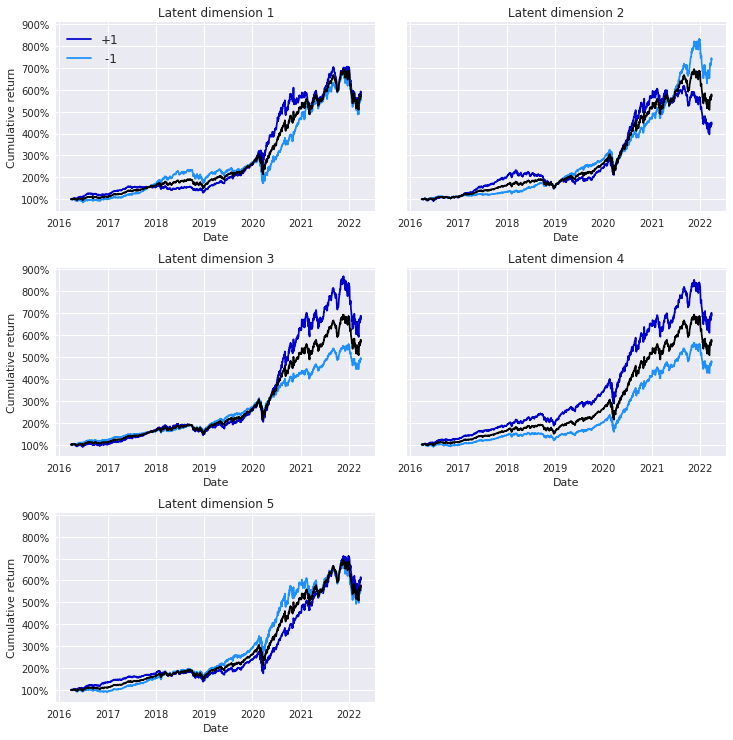

In [22]:
show_latent('AAPL', delta=1)

The example above shows the advantage of using autoencoders for dimension reduction. It avoids the constraints suffered by PCA and manages to holistically capture meaningful pattern. The embedding learned by autoencoders from asset returns can better reflect asset similarity.